# Install/import related packages

In [1]:
# the code works in Python 3.6.
!pip install simpletransformers

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the '/opt/rh/rh-python36/root/usr/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from simpletransformers.classification import ClassificationModel

# Set the global varibles
These varibles are task-specific and are used in the whole process.

In [17]:
# Data related
data_dir = './data'              # the folder that stores train.csv, dev.csv, and test.csv
out_dir = './model'              # where the trained model will be stored
pred_out_file = f'{out_dir}/preds.csv'

# Task related
classes = ['no', 'yes']          # the classes list 

# Model related
sliding_window_flag = 1          # whether the sliding window is used or not
max_epoch = 3                    # how many epochs for training
learning_rate = 2e-5             # the peak learning rate. usually a small data needs a small learning rate.

# Load the train, dev, and test dataset
When loading the datasets, if the labels are not numbers, we need to convert the text labels into numbers.
Also, the model output will be numbers rather than text labels.

In [12]:
import pandas as pd

'''
Load data from the csv file and convert into the format that the model can read.

@params:
    dat_file:   the csv file
    is_train:   whether the csv file is a training set
    sep:        the deliminator for the csv file (default is the comma)
    text_name:  the columne name of the text column in the csv file 
    label_name: the columne name of the label column in the csv file 
    classes:    the list of all classes
    label_map:  whether the label needs to be mapped into a number

@return: a DataFrame with the `text` and `labels` column
'''
def load_data(
    dat_file,
    is_train=False,
    sep=',',
    text_name='text',
    label_name='label',
    classes = [],
    label_map = False
    ):

    df = pd.read_csv(dat_file, usecols=[text_name, label_name], sep=sep)

    # if it is a training set, do random shuffling
    if is_train:
        df = df.sample(frac=1).reset_index(drop=True)

    df = df.dropna()
    df = df.rename(columns={label_name:'labels'}) # the label name for the model is defaultly set as "labels"
    print(df.head())

    # If the label is text, it needs to be converted into numbers.
    # We used the index of the classes list as the new labels. 
    # For example, if the classes are ['F', 'M'], all 'F' labels are mapped into 0, and the left are mapped into 1.
    if label_map:        
        df['labels'] = df['labels'].apply(classes.index)

        print('after mapping:')
        print(df.head())
    
    print('size:', len(df))    
    return df

In [13]:
df_train = load_data(f'{data_dir}/train.csv', is_train=True, classes=classes, label_map=True)

                                                text labels
0  @UTDTrey We can all agree  now that arsenal is...     no
1  Massages Can Alleviate Headaches \nWhether you...     no
2  NAH HOW AM I SUPPOSED TO LIVE KNOWING THAT HOB...     no
3  The way you carry yourself, your personality,c...     no
4  My aura is 'Vivid Violet'✨ https://t.co/yCnt1t...    yes
after mapping:
                                                text  labels
0  @UTDTrey We can all agree  now that arsenal is...       0
1  Massages Can Alleviate Headaches \nWhether you...       0
2  NAH HOW AM I SUPPOSED TO LIVE KNOWING THAT HOB...       0
3  The way you carry yourself, your personality,c...       0
4  My aura is 'Vivid Violet'✨ https://t.co/yCnt1t...       1
size: 7


In [14]:
df_val = load_data(f'{data_dir}/dev.csv', is_train=False, classes=classes, label_map=True)

                                                text labels
0  Exciting, but...\n...do we need new drugs or d...     no
1  Been in and out of sleep for the last 12 hours...    yes
2  @yung_gravestone You weren’t supposed to talk ...     no
3  As of now these migraines have been kicking my...    yes
4  @AG_EM33 When I had migraines they were induce...    yes
after mapping:
                                                text  labels
0  Exciting, but...\n...do we need new drugs or d...       0
1  Been in and out of sleep for the last 12 hours...       1
2  @yung_gravestone You weren’t supposed to talk ...       0
3  As of now these migraines have been kicking my...       1
4  @AG_EM33 When I had migraines they were induce...       1
size: 5


In [15]:
df_test = load_data(f'{data_dir}/test.csv', is_train=False, classes=classes, label_map=True)

                                                text labels
0                   @NinjaBotRevived is doodoo, kid.     no
1  @AgileCrusade {It was then that Sydney felt Au...     no
2     atlas six is giving me migraine. my head hurts    yes
3  Apmg I GOYAAT figt for my life TOO GET THESE T...     no
4  I love that I can script out my migraines beca...    yes
after mapping:
                                                text  labels
0                   @NinjaBotRevived is doodoo, kid.       0
1  @AgileCrusade {It was then that Sydney felt Au...       0
2     atlas six is giving me migraine. my head hurts       1
3  Apmg I GOYAAT figt for my life TOO GET THESE T...       0
4  I love that I can script out my migraines beca...       1
size: 6


# Model training

## Set up the hyper-parameters

In [10]:
model_args = ClassificationArgs()

# model architecture
model_args.sliding_window = sliding_window_flag
model_args.max_seq_length = 512
model_args.train_batch_size = 32
model_args.num_train_epochs = max_epoch

# input data process
model_args.reprocess_input_data = True
model_args.overwrite_output_dir = True

# save checkpoints
model_args.best_model_dir = f'{out_dir}/best_model' # the best model will be stored
model_args.evaluate_during_training = True

# early stopping config
model_args.use_early_stopping = True                 # stop training if the loss does not change for several steps

# other
model_args.learning_rate = learning_rate

## Create a classification model
The class `ClassificationModel` is used to create the model, and the model is initialized from `roberta`.

In [7]:
model = ClassificationModel("roberta", "roberta-base", num_labels=len(classes), use_cuda=True, args=model_args) 

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.weight', 'classifier.out

## Start training the model

In [8]:
model.train_model(df_train, eval_df=df_val, output_dir=out_dir)

(342, 0.22405507641828112)

# Model inference/prediction
After training, we can make the model predict on the testing set.
The output consists of the prediction and the vector of logits. The vecter size is the same as the number of classes.

In machine learning, logits are interpreted to be the unnormalised predictions of a model. We apply softmax to it to get a probability distribution over the classes.

In [30]:
test_text = df_test['text']
predictions, raw_outputs = model.predict(test_text)
print('predictions:\n', predictions)
print('logits:\n', raw_outputs)

array([[ 2.69726562, -2.95507812],
       [-2.03515625,  2.28515625],
       [ 2.98828125, -2.98242188],
       ...,
       [ 2.92773438, -2.89648438],
       [ 2.33984375, -2.59570312],
       [ 2.86523438, -2.9921875 ]])

In [63]:
import numpy as np
def softmax(x, axis=None):
    x = x - x.max(axis=axis, keepdims=True)
    y = np.exp(x)
    return y / y.sum(axis=axis, keepdims=True)

logits=np.asarray(raw_outputs)
probas=softmax(logits, axis=1)
print('normalized logits:\n', probas)

In [ ]:
# store the predictions to a csv file seperated by '\t'
with open(pred_out_file, 'w') as fw:
    fw.write('index\tprediction\n')
    for i, pred in enumerate(predictions):
        fw.write(f'{i}\t{pred}\n')

# Model evaluation

In [72]:
test_labels = df_test['labels'] 
report = classification_report(test_labels, predictions)
print(report)

array([[0.99717717, 0.00282283],
       [0.99763574, 0.00236426],
       [0.01366313, 0.98633687],
       ...,
       [0.98048745, 0.01951255],
       [0.07620119, 0.92379881],
       [0.99019718, 0.00980282]])

# Plot the confusion matrix

              precision    recall  f1-score   support

           0       0.97      0.92      0.95       761
           1       0.84      0.94      0.88       328

    accuracy                           0.93      1089
   macro avg       0.90      0.93      0.91      1089
weighted avg       0.93      0.93      0.93      1089

overall Accuracy: 0.9256198347107438


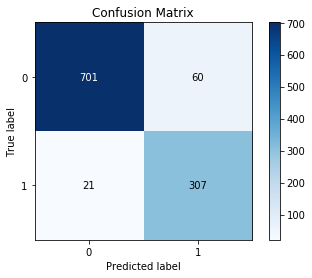

--------------------------


In [80]:
import scikitplot
import matplotlib.pyplot as plt
cm = confusion_matrix(test_labels, predictions)
scikitplot.metrics.plot_confusion_matrix(test_labels, predictions)
plt.show()

print('--------------------------')
